# Recurrent Neural Network for Binary Classification Using Spectrograms

### Some Setup

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

print("In Colab: {}".format(IN_COLAB))

if IN_COLAB:
  !pip install torchmetrics
  !pip install kornia
  !pip install torchvision
  !pip install pychorus
  google.colab.drive.mount('/content/drive')
  %cd /content/drive/My Drive/Go-Viral-Project/notebooks

In Colab: False


Imports

In [18]:
import sys; sys.path.append('..')
import os
import torch
import numpy as np
from torch.utils.data import random_split
import pandas as pd
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn as nn
from src.RNN_utils.dataset import SoundDS
from torch.utils.data import default_collate
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate
from kornia.losses.focal import BinaryFocalLossWithLogits
from pychorus.helpers import find_and_output_chorus
import IPython.display as ipd
import librosa
import torchaudio
from src.utils.plot_utils import plot_spectrogram
from src.utils.file_utils import create_dirs_if_not_exist
from src.RNN_utils.audio_utils import rechannel, get_chorus, createSpect
from torchmetrics.classification import ConfusionMatrix

Setting paths

In [7]:
AUDIO_PATH = '../data/audio_mp3'
TENSOR_PATH = '../data/specs'
METADATA_PATH = '../data/audio_features.csv'

 Setting seed for reproducability

In [4]:
SEED = 42
torch.manual_seed(SEED)

Setting device

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cpu


In [ ]:
import matplotlib.pyplot as plt

def plotTrainRes(resutls, num_epochs):
    fig, axs = plt.subplots(1,2, figsize=(15,5))

    axs[0].plot(range(num_epochs), resutls['loss'])
    axs[0].set_xlabel('epoch')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(num_epochs), resutls['accuracy'])
    axs[1].set_xlabel('epoch')
    axs[1].set_ylabel('accuracy')

## Using RNN for feature extraction from audio input

The internet suggest we should use RNN on spectogram (as omer did with cnn) by considering each column of the spectogram as the current input (in the time dimension) and then using the recurrent network.

Working with the raw audio is not so simple as I originally thought because even if I would use LSTM (which can handle longer sequences than simple RNN), we are talking about sequences of length of ~1e-6 and I think we won't be able to train this well naively. It is possible to do Truncated backpropagation through time (TBPTT) and if time would allow us, we will try that as well but because using spectogram was suggested by the internet, we will go with it.

### Data processing:

#### Playing with the data:

For each song, we will focus only on the chorus. The idea behind this is both in term of performance and in term of computations. In terms of performance, the chorus contains the whole message of the song in just a few lines and also it will be the most powerful, highest energy, loudest, catchiest, and most memorable part of any song. Thus, it make sense that most tiktokers will choose this part for their video. In addition, in term of computation, working on shorter audio file (only the chorus compared to the whole song) / smaller spectogram will require less computations.

In order to do so, we will use pychorus library.

In [8]:
example_mp3 = os.path.join(AUDIO_PATH, '66Cv7Qmdy9d5BYZd7Ch6A7.mp3')
x, sr = librosa.load(example_mp3)
start = find_and_output_chorus(input_file=example_mp3, output_file=None, clip_length=20)
if start:
  start = int(start)

Best chorus found at 1 min 35.60 sec


And now let's plot the predicted chorus and hear it:

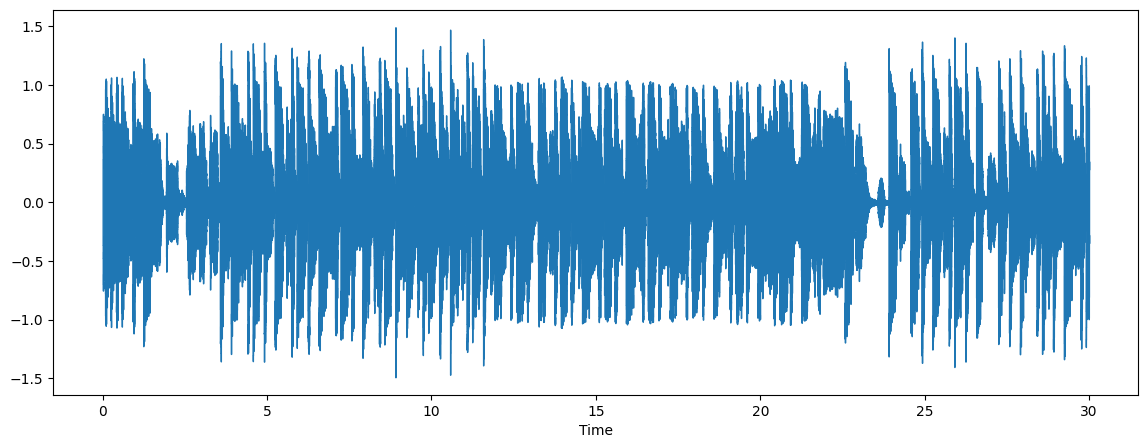

In [9]:
plt.figure(figsize=(14, 5))
if start:
  librosa.display.waveshow(x[start*sr:(start+30)*sr], sr=sr)

In [20]:
chorus = x[start*sr:(start+20)*sr]
ipd.Audio(data = chorus, rate=sr)

and it really sounds like the real chorus (cut in the middle because I limit the duration to be 30 seconds).

Let's try to plot the spectogram of the chorus.

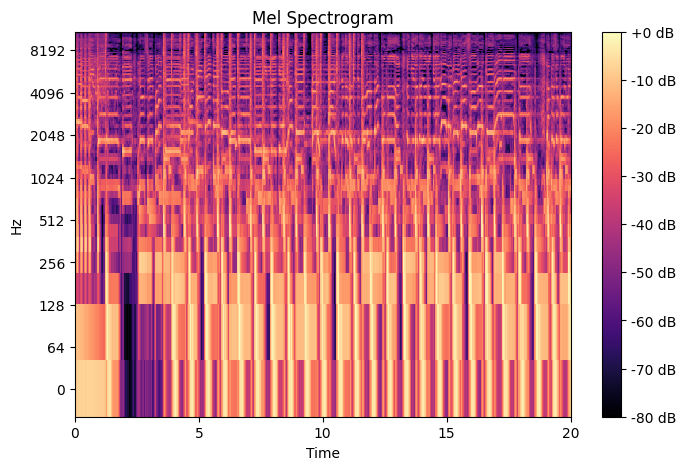

In [13]:
plot_spectrogram(chorus, sr, mel=True)

It seems that the high frequencies as high dB, which might indicate more rhythmic song (in addition to the previous plot where we can see rapid changes in the signal). This in turn can indicate the virality of the song but we will let the model decide it.

Let's create the pipeline of the preprocessing.

#### Preprocessing pipeline:

The following is the basic pipeline:

                Raw audio -> calculate mean of channels -> extract chorus from audio -> create spectorgram from audio -> convert spectogram from amplitude to dB

In order to avoid redundant calculations and speed-up the training time, I will create all spectogram before the training and save them as files and only load them each epoch.

In [21]:
create_dirs_if_not_exist(TENSOR_PATH)
df = pd.read_csv(METADATA_PATH)

Let's start by applying the pipeline on the training set and save the new tensors as files:

In [ ]:
#for idx in tqdm(df.index):
for idx in tqdm(df.index):
    song_path = os.path.join(AUDIO_PATH, df.loc[idx,'id'] + '.mp3')
    #load the audio file
    aud = torchaudio.load(song_path)
    #convert the audio to mono audio
    aud = rechannel(aud,new_channel=1)
    #take only the part of the chorus from the signal
    aud = get_chorus(song_path, 20, aud)
    #create the mel-spectogram
    sgram = createSpect(aud, n_mels=64)
    torch.save(sgram,TENSOR_PATH + '/' + df.loc[idx,'id'] + '.pt')

### Cleaning up the data

In [22]:
df = pd.read_csv(METADATA_PATH)

Setting target using the threshold of $5e5$

In [23]:
df["viral"] = (df["number_of_videos"] > 5e5).astype("int64")

Dropping all features that the model cannot infer from the audio and the new features we created

In [24]:
df.drop(
    [
        "track_name",
        "track_pop",
        "artist",
        "artist_pop",
        "album",
        "number_of_videos" "time_signature",
        "artist_name",
        "total_likes_count",
        "number_of_videos",
        "chroma_stft",
        "rmse",
        "spec_cent",
        "spec_bw",
        "rolloff",
        "zcr",
        "mfcc",
    ],
    axis=1,
    errors="ignore",
    inplace=True,
)

Next, we will remove songs that does not have spectrogram:

In [25]:
data_path = '../data/specs/'
files_not_found = 0

for idx, row in df.iterrows():
    song_path = os.path.join(data_path, row['id'] + '.pt')

    if not os.path.exists(song_path):
        df = df.drop(idx)
        files_not_found += 1

print(f"Number of files not found: {files_not_found}")

Number of files not found: 289


Deleting all songs that could not be downloaded

In [27]:
converted_songs = [song[:-4] for song in os.listdir(AUDIO_PATH)]

df = df[(df["id"].isin(converted_songs))]

Now, let's use the SoundDS class in order to create dataset from those tensors and then create dataloader for both the training and validation (test) sets:

In [28]:
def preprocess_rnn(X):
  _, rows, columns = X.shape

  # remove the channel dimension
  X = X.reshape(rows, columns)

  # Change between the time dimension and the features dimension as LSTM/TransformerEncoder requires
  X = torch.transpose(X,dim0=-2,dim1=-1)

  return X

In [29]:
myds = SoundDS(df, TENSOR_PATH, preprocess=preprocess_rnn)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=16, shuffle=False)

Next we will check that everything is working properly:

In [30]:
inputs, labels = next(iter(train_dl))

In [31]:
print(f'Batch input shape: {inputs.shape}')
print(f'Batch label shape: {labels.shape}')

Batch input shape: torch.Size([16, 2206, 64])
Batch label shape: torch.Size([16])


As we can see, each batch as 16 samples of shape (2206,64) - 2206 windows of time and 64 mel bins of frequencies. The number of channels is only one. Having the data loader, we can now move to the model part!

### The Model:

We will use RNN based model in this notebook.

Because our input is of length 2206 which is pretty long, we won't use the basic RNN unit but the LSTM (Long Short Term Memory). The advantage of LSTM on the basic RNN is the ability to "remember" information from far earlier inputs. In addition,it also handle the vanishing gradient problem which we might suffer from with the basic RNN because we have long sequence inputs.

In [32]:
import torch.nn as nn

In [33]:
class viralCls(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.0, num_classes=2):
        super().__init__()
        self.feature_extractor = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout= dropout if num_layers > 1 else 0.0)
        self.clf = nn.Sequential(
            nn.Linear(hidden_size, 512),
            nn.LeakyReLU(),
            nn.Dropout1d(p=dropout),
            nn.Linear(512, 512),
            nn.Dropout1d(p=dropout),
            nn.LeakyReLU(),
            nn.Linear(512, num_classes),
            nn.Softmax(dim=1)
        )
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_classes = num_classes

    def forward(self,X,h0=None,c0=None):
        batch_size = X.shape[0]
        if h0 is None or c0 is None:
            h0 = torch.normal(mean=0.0,std=1.0,size=(self.num_layers,batch_size,self.hidden_size)).to(device)
            c0 = torch.normal(mean=0.0,std=1.0,size=(self.num_layers,batch_size,self.hidden_size)).to(device)

        #extracting the features from the spectogram.
        out, _ = self.feature_extractor(X, (h0, c0))

        #classifing according to the extracted features.
        prob = self.clf(out[:,-1,:])
        return prob

Let's see if the new classifier is working on random input:

In [34]:
model = viralCls(5,10).to(device)
X = torch.rand(10,20,5).to(device)
model(X).shape

torch.Size([10, 2])

The input is 10 samples, each is with length of 20 and 5 features for each time. The output is probability distribution over 2 classes for all 10 samples. Success!

### The training loop:

As before, I will first create the loaders of the data:

In [35]:
def preprocess_rnn(X):
  _, rows, columns = X.shape

  # remove the channel dimension
  X = X.reshape(rows, columns)

  # Change between the time dimension and the features dimension as LSTM/TransformerEncoder requires
  X = torch.transpose(X,dim0=-2,dim1=-1)

  return X

In [36]:
from src.RNN_utils.dataset import SoundDS
from torch.utils.data import default_collate
myds = SoundDS(df, '../data/specs/',preprocess_rnn)

# Random split of 80:20 between training and validation
num_items = len(myds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val])

to_gpu = lambda x: list(map(lambda t: t.to(device), default_collate(x)))
# Create training and validation data loaders
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=32, collate_fn = to_gpu, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=32, collate_fn = to_gpu, shuffle=False)

In [37]:
b_size, seq_len, input_size = next(iter(train_dl))[0].shape
num_batches = len(train_dl)
hidden_size = 64
print(f'batch size: {b_size}\nseq length: {seq_len}\ninput size: {input_size}')

batch size: 32
seq length: 2206
input size: 64


Let's visualize one spectrogram:

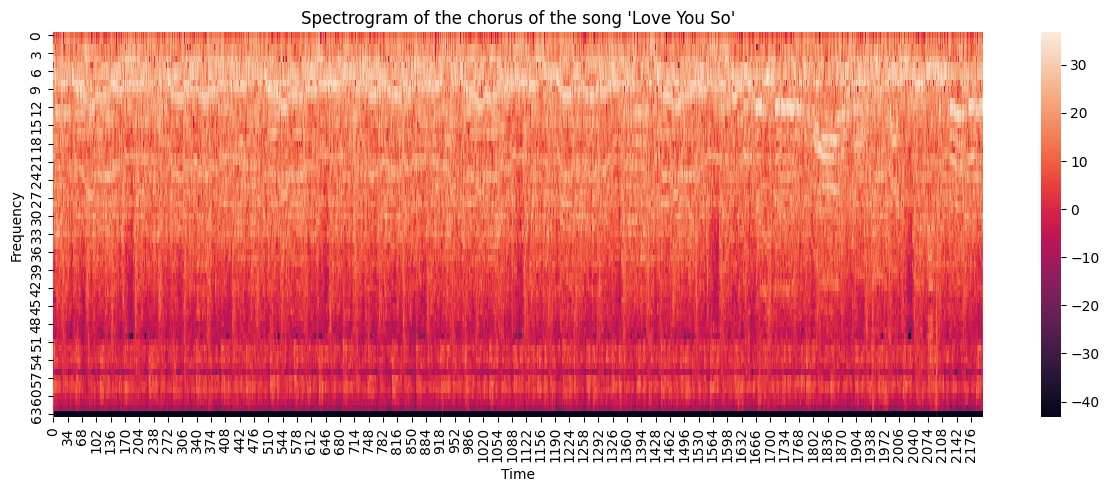

In [38]:
import seaborn as sns

plt.figure(figsize = (15,5))
plt.title("Spectrogram of the chorus of the song 'Love You So'")
ax = sns.heatmap(myds[0][0].t())
ax.set(xlabel='Time', ylabel='Frequency')
plt.show()

#### Overfitting the model:

Let's create the classification model:

In [39]:
model = viralCls(input_size, hidden_size).to(device)

We will use cross entropy loss and Adam optimizer:

In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=5e-3)

epochs = 10

Let's start by train the model to overfitted to the first batch:

In [41]:
(X,y) = next(iter(train_dl))
for epoch in range(epochs):
    optimizer.zero_grad()
    y_prob = model(X)
    loss = criterion(y_prob,y)
    loss.backward()
    optimizer.step()
    loss = loss.item()
    acc = torch.sum(torch.argmax(y_prob,dim=1)==y).item()/32
    #scheduler.step()
    print(f'Epoch #{epoch}: Loss - {loss}, Accuracy - {acc}')

Epoch #0: Loss - 0.6990708112716675, Accuracy - 0.28125
Epoch #1: Loss - 0.5875200629234314, Accuracy - 0.71875
Epoch #2: Loss - 0.5758060216903687, Accuracy - 0.71875
Epoch #3: Loss - 0.5465929508209229, Accuracy - 0.71875
Epoch #4: Loss - 0.4759542644023895, Accuracy - 0.75
Epoch #5: Loss - 0.4260079264640808, Accuracy - 0.96875
Epoch #6: Loss - 0.38009071350097656, Accuracy - 1.0
Epoch #7: Loss - 0.34753933548927307, Accuracy - 1.0
Epoch #8: Loss - 0.3251868486404419, Accuracy - 1.0
Epoch #9: Loss - 0.316772997379303, Accuracy - 1.0


#### Testing the training loop:

In [ ]:
from src.RNN_utils.trainer import trainer
from src.RNN_utils.cross_val import crossValidate

config = {'lr':5e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.5}
model = viralCls(input_size, hidden_size, num_layers=3, dropout=0.0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler,device)

In [ ]:
results = train_model.train(train_dl,40,True)

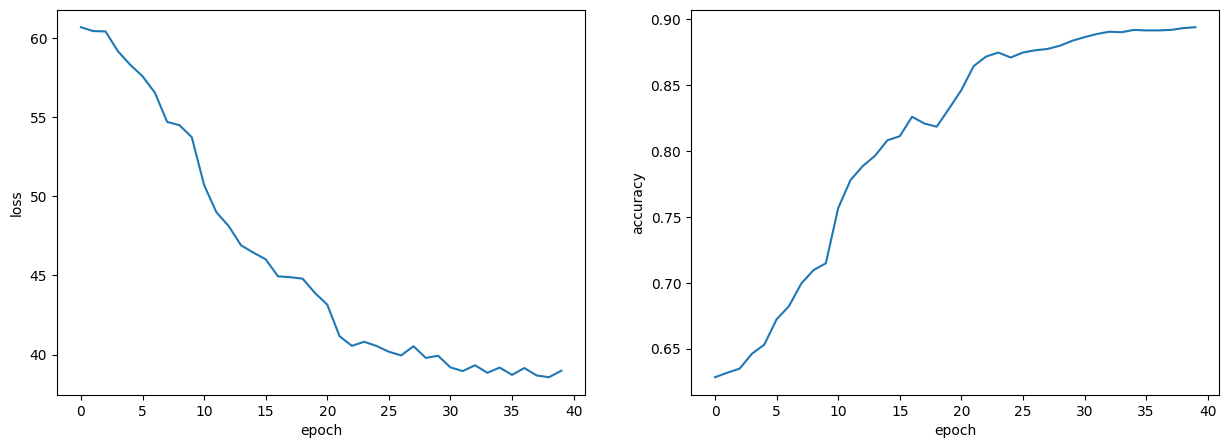

In [ ]:
plotTrainRes(results,40)

In [ ]:
from torchmetrics.classification import ConfusionMatrix

In [ ]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(train_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

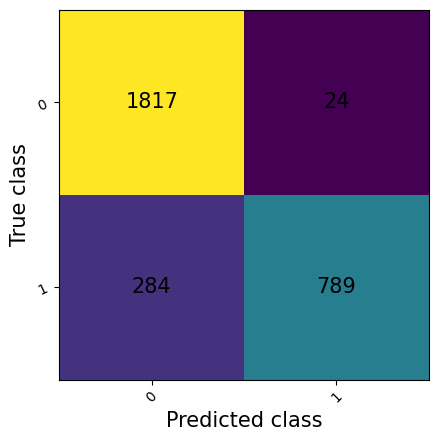

In [ ]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

#### Cross validation:

##### Cross Entropy:

In [ ]:
configs = []
results = []

In [ ]:
# Uncomment one configuration and run this cell
#config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.3}
#config = {'lr':1e-4, 'weight_decay':4e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.4}
#config = {'lr':5e-4, 'weight_decay':6e-5, 'step_size': 8, 'gamma': 0.2, 'dropout': 0.4}
#config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 8, 'gamma': 0.2, 'dropout': 0.5}

model = viralCls(input_size, hidden_size=128, num_layers=3, dropout=config['dropout']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler,device)

In [ ]:
cv_obj = crossValidate(train_ds=train_ds, device=device, folds=3)

In [ ]:
results.append(cv_obj.runCV(train_model, epochs=40))
configs.append(config)

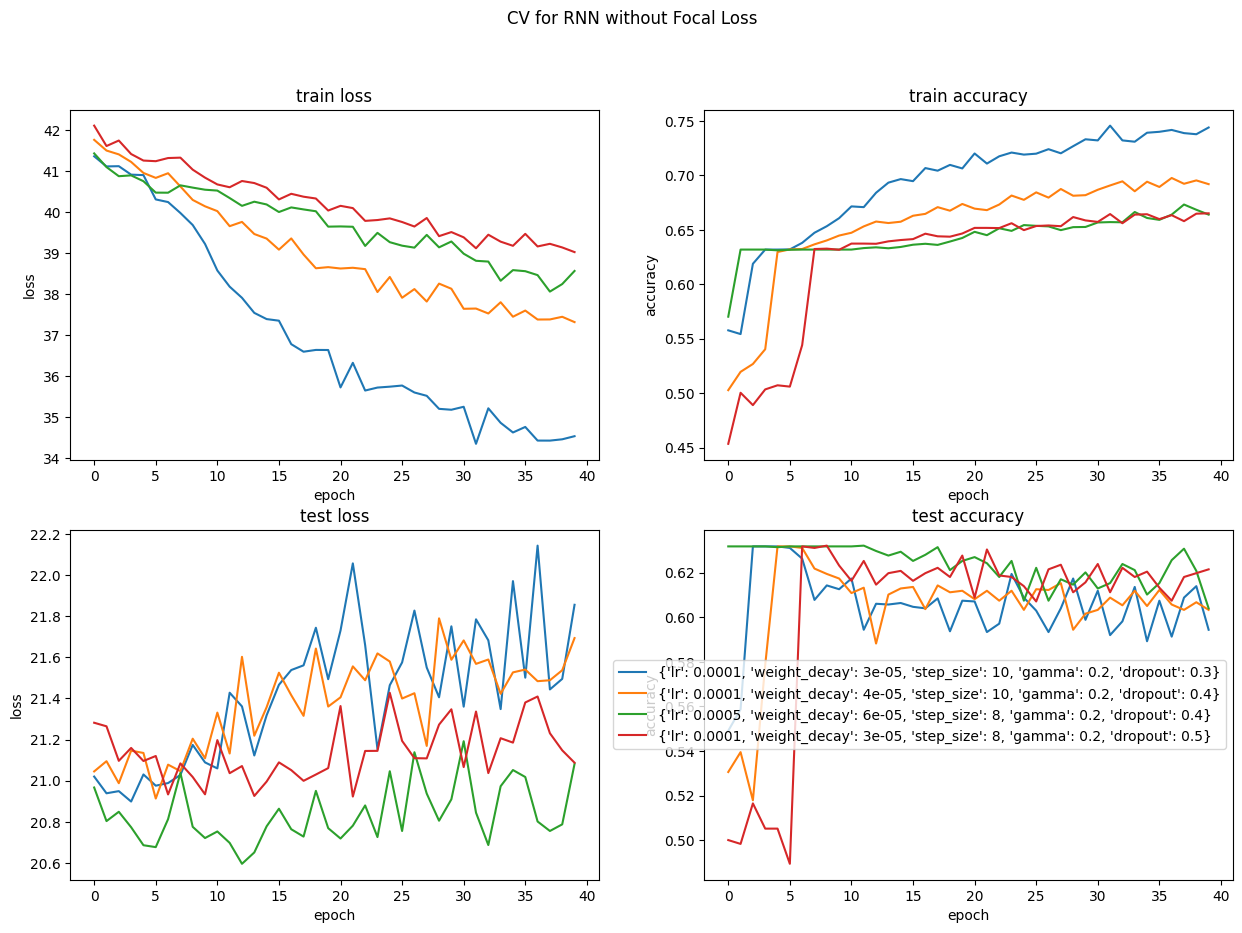

In [ ]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for RNN without Focal Loss')

##### Focal Loss:

In [ ]:
configs = []
results = []

In [ ]:
# Uncomment one configuration and run this cell
#config = {'lr':5e-4, 'weight_decay':3e-5, 'step_size': 8, 'gamma': 0.2, 'dropout': 0.3, 'gamma_fl': 2, 'weight': torch.tensor([1.0,1.0]).to(device)}
#config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.3, 'gamma_fl': 2, 'weight': torch.tensor([1.0,1.0]).to(device)}
#config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.3, 'gamma_fl': 2, 'weight': torch.tensor([1.0,1.3]).to(device)}
#config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.3, 'gamma_fl': 3, 'weight': torch.tensor([1.0,1.0]).to(device)}

model = viralCls(input_size, hidden_size=128, num_layers=3, dropout=config['dropout']).to(device)
criterion = BinaryFocalLossWithLogits(alpha=1.0, gamma=config['gamma_fl'], reduction='mean', weight=config['weight'])
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler,device)

In [ ]:
cv_obj = crossValidate(train_ds=train_ds, device=device, folds=3)

In [ ]:
results.append(cv_obj.runCV(train_model, epochs=40))
configs.append(config)

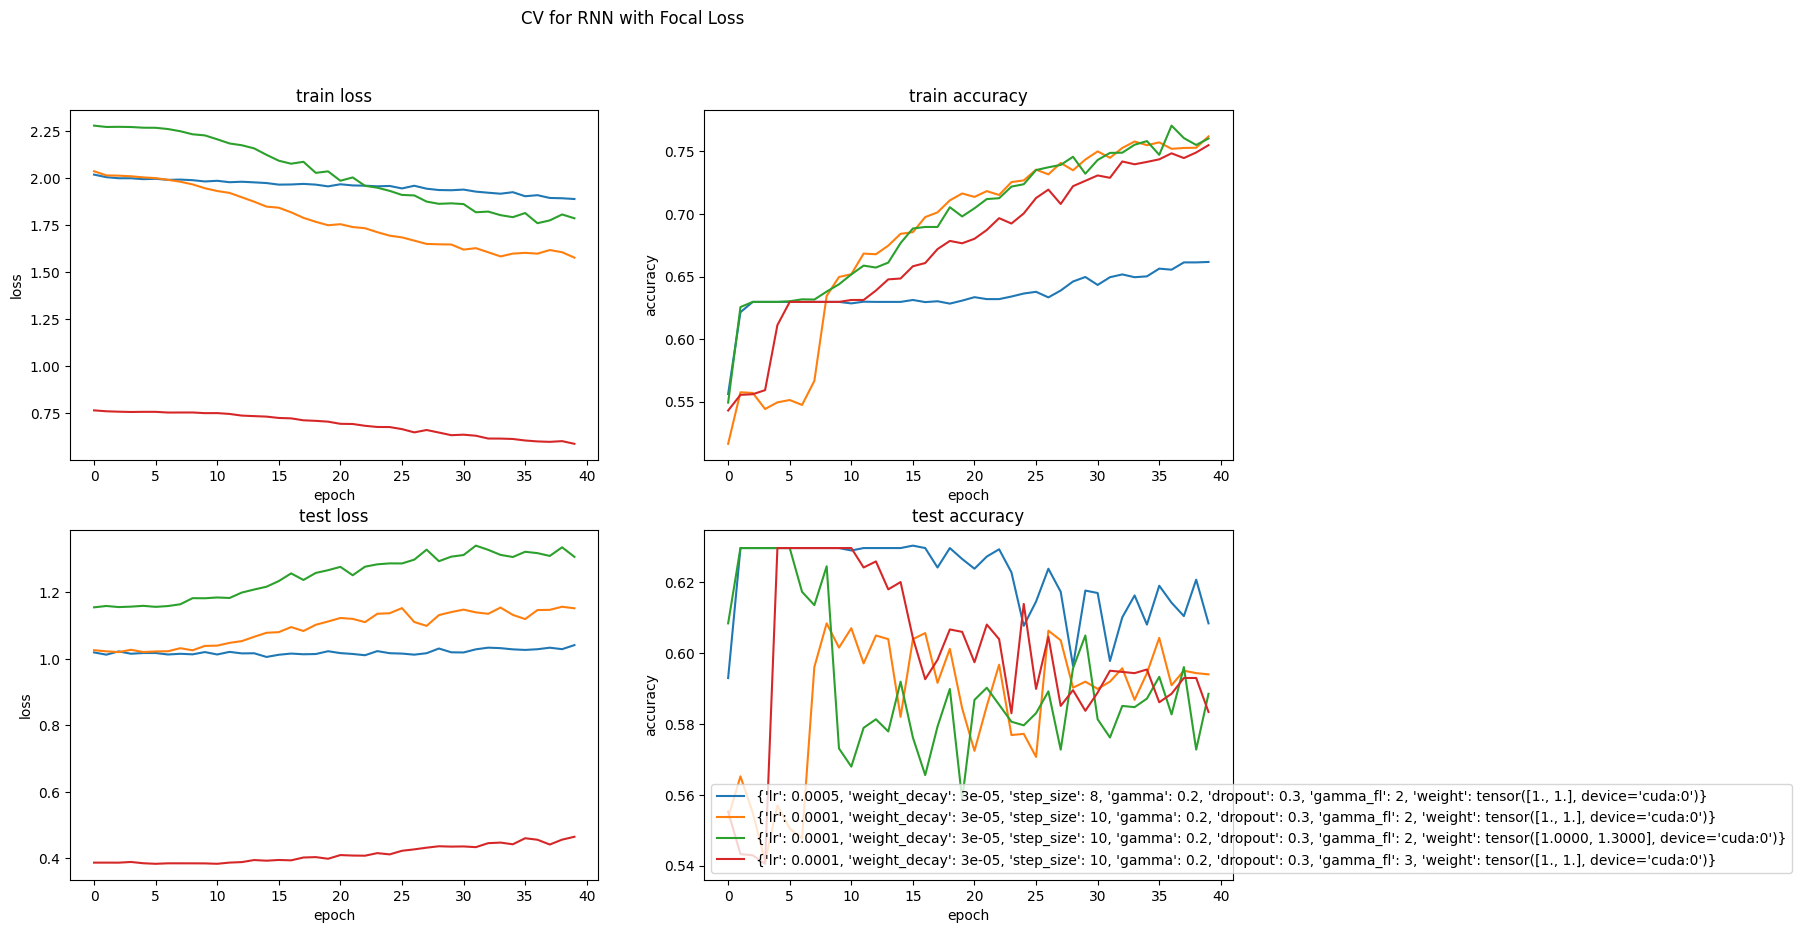

In [ ]:
from src.RNN_utils.cross_val import plotCV

plotCV(results, configs,title='CV for RNN with Focal Loss')

### Full Training:

##### Cross Entropy:

In [ ]:
from src.RNN_utils.trainer import trainer

config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.3}
model = viralCls(input_size, hidden_size=128, num_layers=3, dropout=config['dropout']).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler,device)

In [ ]:
results = train_model.train(train_dl, 50, True)

Train Batch: 100%|██████████| 92/92 [14:41<00:00,  9.58s/it]


Epoch #0: Loss - 62.25102758407593, Accuracy - 0.5521619766643788


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.35it/s]


Epoch #1: Loss - 62.00954759120941, Accuracy - 0.6139327385037748


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.36it/s]


Epoch #2: Loss - 61.06200948357582, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.17it/s]


Epoch #3: Loss - 61.7657485306263, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.43it/s]


Epoch #4: Loss - 61.05760711431503, Accuracy - 0.6317776252573781


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.47it/s]


Epoch #5: Loss - 61.273827373981476, Accuracy - 0.6355525051475635


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.43it/s]


Epoch #6: Loss - 60.93275314569473, Accuracy - 0.6420727522306109


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.44it/s]


Epoch #7: Loss - 60.403242230415344, Accuracy - 0.648936170212766


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.37it/s]


Epoch #8: Loss - 59.28508123755455, Accuracy - 0.6571722717913521


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.42it/s]


Epoch #9: Loss - 58.41551262140274, Accuracy - 0.664378860672615


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.37it/s]


Epoch #10: Loss - 58.32718586921692, Accuracy - 0.668496911461908


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.38it/s]


Epoch #11: Loss - 58.008222222328186, Accuracy - 0.6719286204529856


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.43it/s]


Epoch #12: Loss - 57.81623947620392, Accuracy - 0.6777625257378175


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.41it/s]


Epoch #13: Loss - 56.37317696213722, Accuracy - 0.6908030199039121


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.45it/s]


Epoch #14: Loss - 56.47052776813507, Accuracy - 0.6932052161976664


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.31it/s]


Epoch #15: Loss - 55.9021577835083, Accuracy - 0.6908030199039121


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.44it/s]


Epoch #16: Loss - 56.76093381643295, Accuracy - 0.7028140013726836


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.35it/s]


Epoch #17: Loss - 56.36677801609039, Accuracy - 0.6921757035003432


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.42it/s]


Epoch #18: Loss - 56.228602796792984, Accuracy - 0.6959505833905285


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.41it/s]


Epoch #19: Loss - 56.181241035461426, Accuracy - 0.6877144818119424


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.42it/s]


Epoch #20: Loss - 55.97412472963333, Accuracy - 0.7031571722717913


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.39it/s]


Epoch #21: Loss - 55.414560079574585, Accuracy - 0.7028140013726836


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.41it/s]


Epoch #22: Loss - 56.24434494972229, Accuracy - 0.6962937542896362


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.37it/s]


Epoch #23: Loss - 55.052853375673294, Accuracy - 0.714824982841455


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.40it/s]


Epoch #24: Loss - 55.43585568666458, Accuracy - 0.7089910775566232


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.42it/s]


Epoch #25: Loss - 55.755307734012604, Accuracy - 0.7069320521619766


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.44it/s]


Epoch #26: Loss - 55.22955933213234, Accuracy - 0.7076183939601922


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.42it/s]


Epoch #27: Loss - 55.79802429676056, Accuracy - 0.6997254632807138


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.39it/s]


Epoch #28: Loss - 55.68219006061554, Accuracy - 0.7028140013726836


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.42it/s]


Epoch #29: Loss - 54.68849703669548, Accuracy - 0.712079615648593


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.45it/s]


Epoch #30: Loss - 55.178376495838165, Accuracy - 0.7134522992450241


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.45it/s]


Epoch #31: Loss - 55.89074403047562, Accuracy - 0.7059025394646534


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.39it/s]


Epoch #32: Loss - 55.24368703365326, Accuracy - 0.7103637611530542


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.36it/s]


Epoch #33: Loss - 55.84637054800987, Accuracy - 0.6945778997940975


Train Batch: 100%|██████████| 92/92 [00:15<00:00,  6.10it/s]


Epoch #34: Loss - 55.31149783730507, Accuracy - 0.7045298558682224


Train Batch: 100%|██████████| 92/92 [00:15<00:00,  6.11it/s]


Epoch #35: Loss - 55.522029876708984, Accuracy - 0.7055593685655457


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.41it/s]


Epoch #36: Loss - 55.227212727069855, Accuracy - 0.7137954701441318


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.38it/s]


Epoch #37: Loss - 55.55267831683159, Accuracy - 0.7024708304735758


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.41it/s]


Epoch #38: Loss - 55.453073620796204, Accuracy - 0.7041866849691146


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.39it/s]


Epoch #39: Loss - 54.55840340256691, Accuracy - 0.7199725463280714


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.43it/s]


Epoch #40: Loss - 55.59347781538963, Accuracy - 0.7031571722717913


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.40it/s]


Epoch #41: Loss - 55.67001551389694, Accuracy - 0.7055593685655457


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.40it/s]


Epoch #42: Loss - 55.15084594488144, Accuracy - 0.7151681537405628


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.41it/s]


Epoch #43: Loss - 54.92884677648544, Accuracy - 0.714824982841455


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.39it/s]


Epoch #44: Loss - 54.96460118889809, Accuracy - 0.710706932052162


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.34it/s]


Epoch #45: Loss - 55.92667555809021, Accuracy - 0.7100205902539465


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.40it/s]


Epoch #46: Loss - 55.24010369181633, Accuracy - 0.7155113246396706


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.32it/s]


Epoch #47: Loss - 54.81584131717682, Accuracy - 0.7110501029512697


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.39it/s]


Epoch #48: Loss - 55.68699753284454, Accuracy - 0.710706932052162


Train Batch: 100%|██████████| 92/92 [00:14<00:00,  6.30it/s]

Epoch #49: Loss - 55.29284048080444, Accuracy - 0.7065888812628689


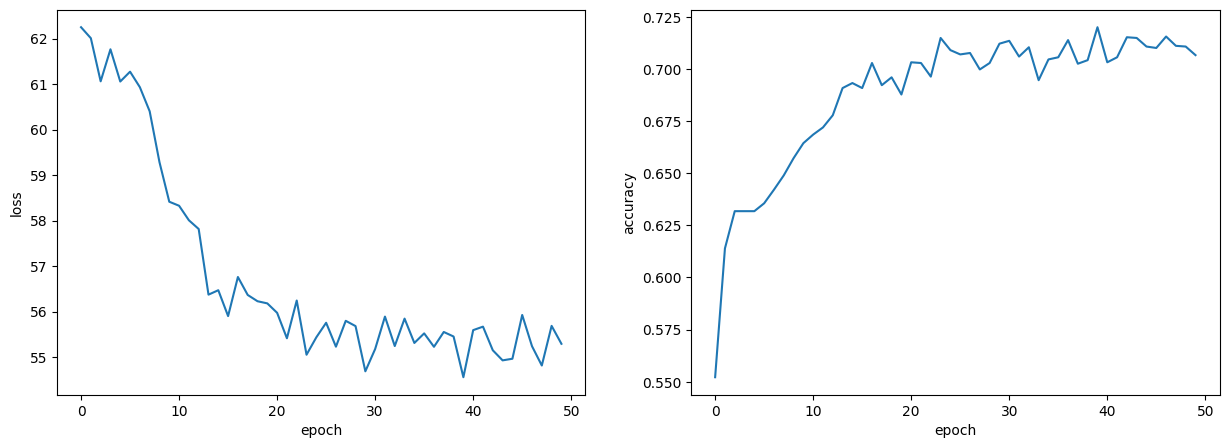

In [ ]:
plotTrainRes(results,50)

In [ ]:
train_model.evaluate(val_dl, True)

Test Batch: 100%|██████████| 23/23 [03:43<00:00,  9.71s/it]

Val results: Loss - 15.628232955932617, Accuracy - 0.6296296296296297


(15.628232955932617, 0.6296296296296297)

In [ ]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(train_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

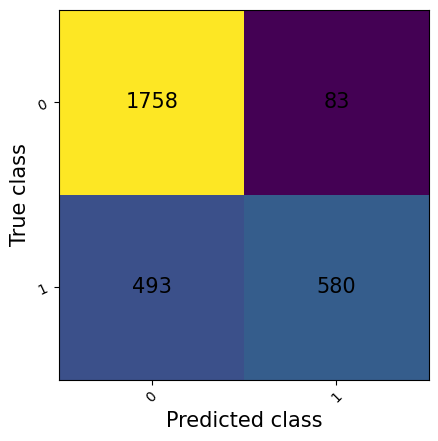

In [ ]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

In [ ]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(val_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

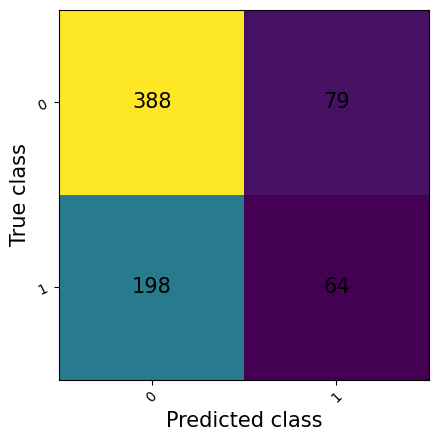

In [ ]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

##### Focal Loss:

In [ ]:
from src.RNN_utils.trainer import trainer

config = {'lr':1e-4, 'weight_decay':3e-5, 'step_size': 10, 'gamma': 0.2, 'dropout': 0.3, 'gamma_fl': 2, 'weight': torch.tensor([1.0,1.0]).to(device)}
model = viralCls(input_size, hidden_size=128, num_layers=3, dropout=config['dropout']).to(device)
criterion = BinaryFocalLossWithLogits(alpha=1.0, gamma=config['gamma_fl'], reduction='mean', weight=config['weight'])
optimizer = torch.optim.Adam(model.parameters(),lr=config['lr'], weight_decay=config['weight_decay'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=config['step_size'],gamma=config['gamma'])

train_model = trainer(model,criterion,optimizer,scheduler,device)

In [ ]:
results = train_model.train(train_dl, 50, True)

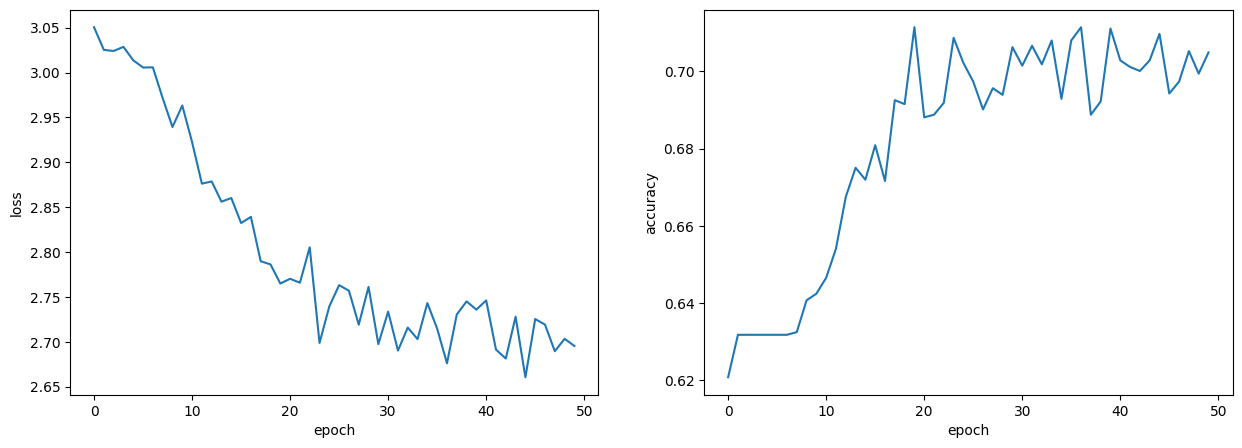

In [ ]:
plotTrainRes(results,50)

In [ ]:
train_model.evaluate(val_dl, True)

Test Batch: 100%|██████████| 23/23 [00:03<00:00,  6.23it/s]

Val results: Loss - 0.791523564606905, Accuracy - 0.6104252400548696


(0.791523564606905, 0.6104252400548696)

In [ ]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(train_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

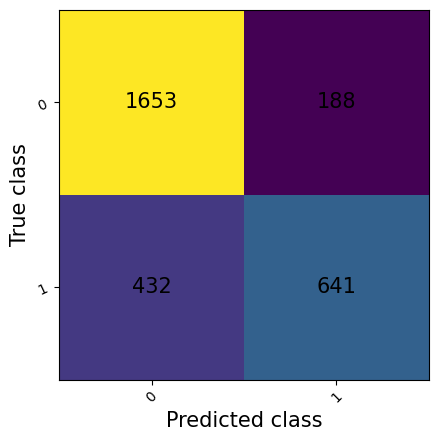

In [ ]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()

In [ ]:
prob_list = []
target_list = []

train_model.model.eval()
for (X,y) in iter(val_dl):
  with torch.no_grad():
    prob_list.append(train_model.model(X))
    target_list.append(y)

pred = torch.cat(prob_list,dim=0).to(torch.device('cpu'))
y = torch.cat(target_list,dim=0).to(torch.device('cpu'))

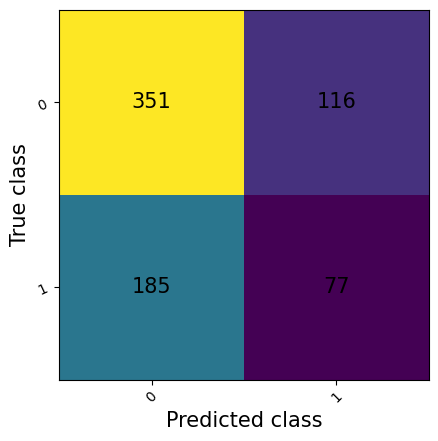

In [ ]:
metric = ConfusionMatrix(task='binary', num_classes=2)
metric.update(pred[:,1], y)
fig_, ax_ = metric.plot()